In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

## Reading the dataset

In [10]:
# /kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
# /kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv

train_data = pd.read_csv('data/Corona_NLP_train.csv',
                        encoding='latin_1')
test_data = pd.read_csv("data/Corona_NLP_test.csv",encoding='latin_1')

In [11]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [12]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## Check for any null value/s  

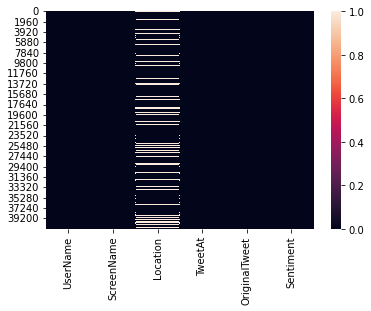

In [13]:
# check for null value in train_data
sns.heatmap(train_data.isnull());

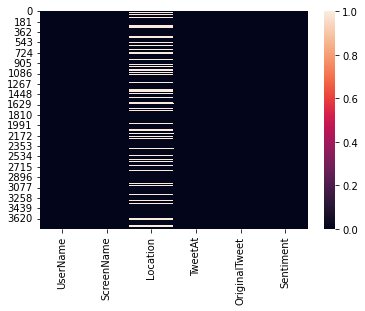

In [14]:
# check for null values in test data
sns.heatmap(test_data.isnull());

## drop duplicate and 'NA' value/s 

In [15]:
train_data.drop_duplicates(inplace= True)
test_data.drop_duplicates(inplace=True)


In [16]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

## Making checkpoint 

In [17]:
# copy the dataset into new data
train_df = train_data.copy()
test_df = test_data.copy()

In [18]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive


## check if any null value exists?

In [19]:
print(train_df.isnull().sum())
print("*"*50)
print(test_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [20]:
train_data.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

## performing small EDA

In [21]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


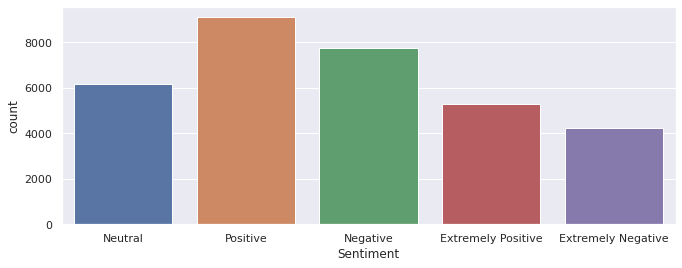

In [22]:
sns.countplot(train_df['Sentiment'])

In [23]:
train_df.shape, test_df.shape

((32567, 6), (2964, 6))

**As we can see we have 5 types of sentiment (but we can make extremely positive into positive and extremely negative into negative )** 

In [24]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

### Applying the change_sen function/method  

In [25]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


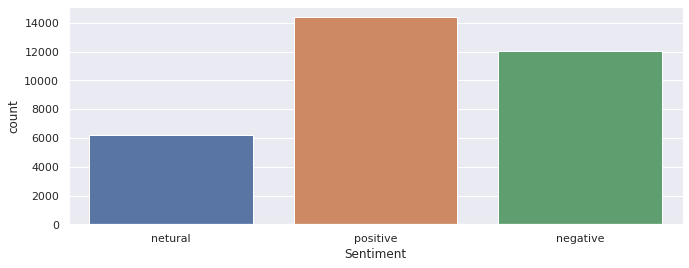

In [26]:
sns.countplot(train_df['Sentiment'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


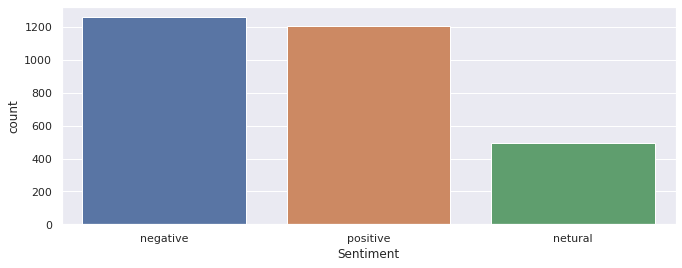

In [27]:
sns.countplot(test_df['Sentiment'])

### Data Cleaning and processing

In [30]:
# load stop words
nltk.download('stopwords')
stop_word = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
      
    return text

In [32]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))

In [33]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,netural
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news regionÂs first confirmed COVID- case ...,positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier grocery store sharing insights To prov...,positive


### We only need "OriginalTweet" and "Sentiment"

In [34]:
df_train = train_df.iloc[:,4:]
df_test = test_df.iloc[:,4:]

In [35]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


### Mapping the sentiment  
- 0: Netural 
- 1: Positive
- 2: Negative

In [36]:
l = {"netural":0, "positive":1,"negative":2}

In [37]:
df_train['Sentiment'] = df_train['Sentiment'].map(l)
df_test['Sentiment']  = df_test['Sentiment'].map(l)

In [38]:
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice Talk neighbours family exchange phone n...,1
2,Coronavirus Australia: Woolworths give elderly...,1
5,As news regionÂs first confirmed COVID- case ...,1
6,Cashier grocery store sharing insights To prov...,1


In [39]:
x_train = df_train['OriginalTweet'].copy()
x_test = df_test['OriginalTweet'].copy()

y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()

In [40]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

#### Max length of sequence  

In [41]:
max_len = np.max(x_train.apply(lambda x :len(x)))

In [42]:
max_len

286

### Tokenizer initlization  

In [43]:
tokenizer = Tokenizer()

In [44]:
tokenizer.fit_on_texts(x_train)
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [45]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 31759
Max sequence length: 286


In [46]:
embedding_dim = 16

## Model Creation  

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [48]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 286, 16)           508144    
                                                                 
 bidirectional (Bidirectiona  (None, 286, 512)         420864    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

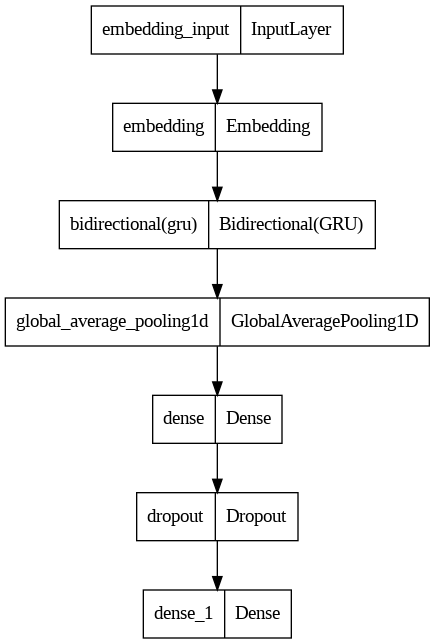

In [49]:
tf.keras.utils.plot_model(model)

In [50]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((32567, 286), (2964, 286), (32567,), (2964,))

In [51]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

## Model training 🥱

In [52]:
num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test))

Epoch 1/10
1018/1018 [==============================] - 1610s 2s/step - loss: 0.9268 - accuracy: 0.5444 - val_loss: 0.7443 - val_accuracy: 0.6653
Epoch 2/10
1018/1018 [==============================] - 1734s 2s/step - loss: 0.7132 - accuracy: 0.7361 - val_loss: 0.5576 - val_accuracy: 0.7999
Epoch 3/10
1018/1018 [==============================] - 1732s 2s/step - loss: 0.5257 - accuracy: 0.8328 - val_loss: 0.4896 - val_accuracy: 0.8256
Epoch 4/10
1018/1018 [==============================] - 1688s 2s/step - loss: 0.4155 - accuracy: 0.8723 - val_loss: 0.4766 - val_accuracy: 0.8215
Epoch 5/10
1018/1018 [==============================] - 1703s 2s/step - loss: 0.3284 - accuracy: 0.8998 - val_loss: 0.6026 - val_accuracy: 0.8111
Epoch 6/10
1018/1018 [==============================] - 1540s 2s/step - loss: 0.2809 - accuracy: 0.9121 - val_loss: 0.5164 - val_accuracy: 0.8435
Epoch 7/10
1018/1018 [==============================] - 1315s 1s/step - loss: 0.2279 - accuracy: 0.9365 - val_loss: 0.5945 -

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Model Accuracy and loss  

In [54]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")


Accuracy on training data is:- 95.25593519210815 %
Loss 16.345445811748505
Accuracy on validation data is:- 82.82725811004639 %
Loss 78.1722903251648


## Plotting  

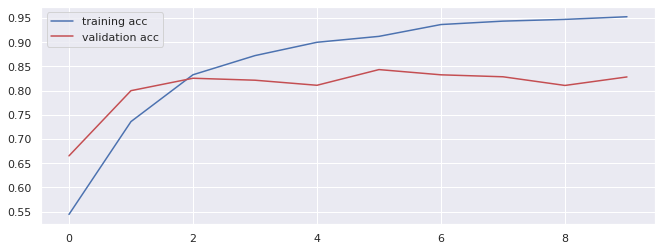

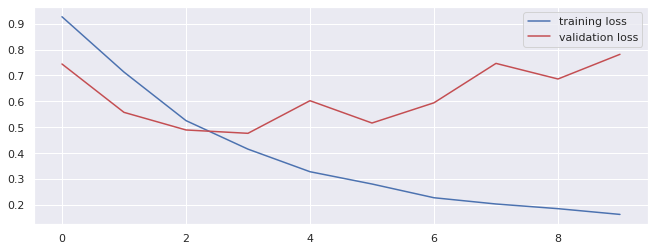

In [55]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()


In [59]:
# pred = model.predict_classes(x_test)

pred =model.predict(x_test) 
classes_x=np.argmax(pred,axis=1)


93/93 [==============================] - 38s 392ms/step


In [64]:
classes_x

array([2, 1, 2, ..., 1, 0, 1])

## Confusion Matrix  

In [66]:
cm = confusion_matrix(np.argmax(y_test,1),classes_x)
cm

array([[ 393,   46,   58],
       [  67, 1011,  129],
       [  82,  127, 1051]])

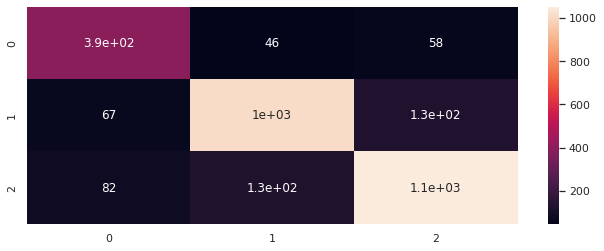

In [67]:
sns.heatmap(cm,annot=True)

## Classification Report  

In [68]:
print(classification_report(np.argmax(y_test,1),classes_x))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       497
           1       0.85      0.84      0.85      1207
           2       0.85      0.83      0.84      1260

    accuracy                           0.83      2964
   macro avg       0.81      0.82      0.81      2964
weighted avg       0.83      0.83      0.83      2964



# Assignment 3 labels

In [70]:
chosen_data = pd.read_csv('data/Corona_NLP_chosen.csv', encoding='latin_1')

chosen_data['OriginalTweet'] = chosen_data['OriginalTweet'].apply(lambda x: clean(x))
chosen_to_label = chosen_data['OriginalTweet'].copy()

chosen_to_label = tokenizer.texts_to_sequences(chosen_to_label)

chosen_to_label = pad_sequences(chosen_to_label, maxlen=max_len, padding='post')


pred_chosen = model.predict(chosen_to_label) 
chosen_labels =np.argmax(pred_chosen,axis=1)




1/1 [==============================] - 0s 323ms/step


In [71]:
chosen_labels. # 1 is positive, 2 is negative, 0 is neutral

array([1, 0, 2, 1, 2, 2, 1, 1, 1, 2])

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')